# Binary Prediction of Smoker Status using Bio-Signals

# Introduction

- Objective- To predict a patients smoking status based on the information about various health indicators obtained from bio signals located at various parts of human body. 
- The evaluation of the competition is based on the Area under ROC Curve
- The main obstacle in the challenge is that the test target data needs to be in probability,wheareas  the train target data is in binary.

# Import

In [1]:
import warnings

import cmle
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler ,RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, train_test_split
warnings.filterwarnings('ignore')

#  Introducing the Bio-Signals Dataset

In [2]:
df = pd.read_csv("data/Project/train.csv")
train_df, valid_df = train_test_split(df, test_size=0.10, random_state=123)
test_df = pd.read_csv("data/Project/test.csv")
train_df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
156976,156976,45,155,75,90.0,1.5,1.5,1,1,120,...,77,114,13.1,1,0.4,19,17,105,0,1
131121,131121,50,160,75,95.0,1.5,1.2,1,1,140,...,35,100,16.1,1,1.1,39,60,62,0,0
30853,30853,30,170,70,87.0,1.2,1.2,1,1,145,...,46,220,17.5,1,1.1,31,35,38,0,0
88920,88920,40,165,75,88.0,1.0,0.7,1,1,118,...,47,145,14.4,1,0.8,16,14,21,0,0
55357,55357,55,175,75,88.0,1.2,0.7,1,1,130,...,56,104,14.8,1,0.8,40,64,61,0,1


In [3]:
print(df.shape)
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(159256, 24)
(143330, 24)
(15926, 24)
(106171, 23)


# Visualizing features

In [4]:
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


### Exploaratory Data Analysis

- Dataset Size    :   159,256 entries.
- Memory Size     :   29.2 MB.
- Number of Columns   :   24 columns with health and demographic information.
- Number of Features  :   22 
- Target Column   :   'smoking'
- Data Types      :    Mainly integers (int64) and floating-point numbers (float64). There are no non-null entries in the dataset

Key Features that are used to determin if a person is smoker or not is given below
- Demographics: Includes age, height, weight, and waist measurements.
- Sensory Health: Information on eyesight and hearing for both left and right.
- Cardiovascular Health: Systolic and diastolic blood pressure readings.
- Blood Chemistry: Fasting blood sugar, cholesterol (HDL, LDL), triglyceride levels.
- Biometrics: Hemoglobin levels, urine protein, serum creatinine, AST, ALT, Gtp values.
- Lifestyle Factors: Dental caries 

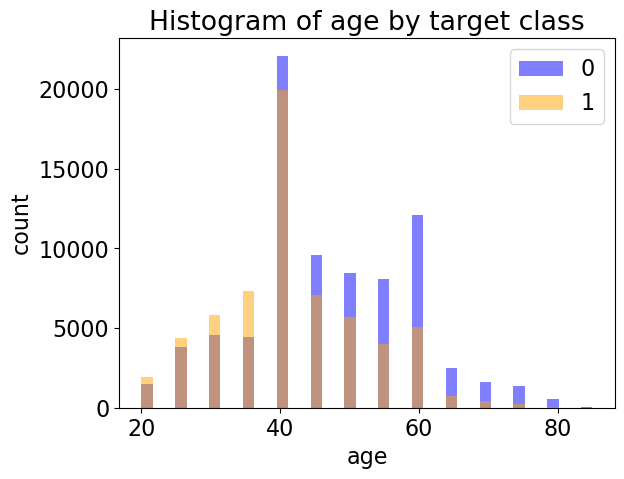

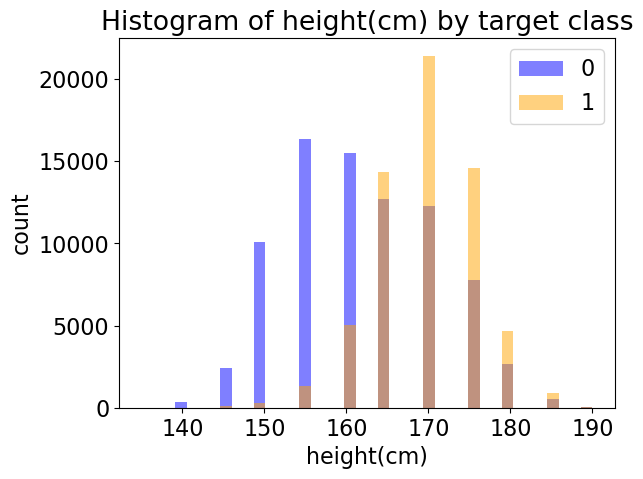

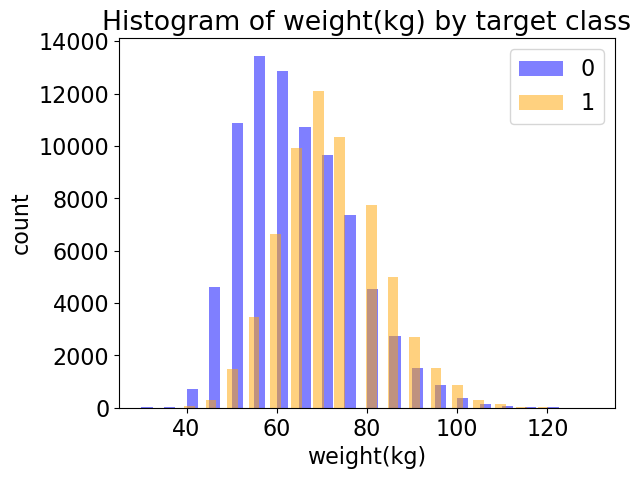

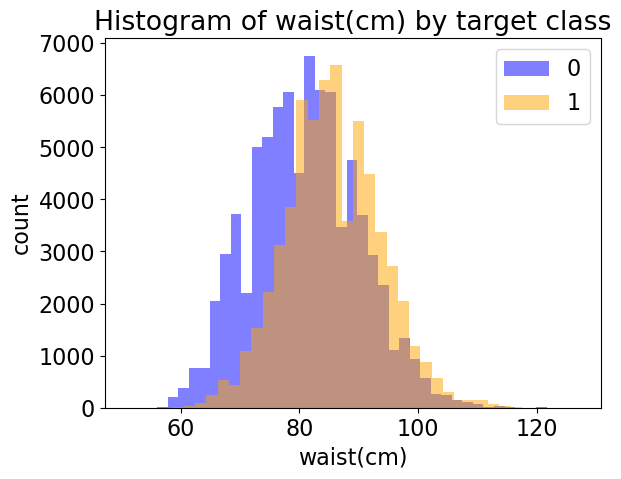

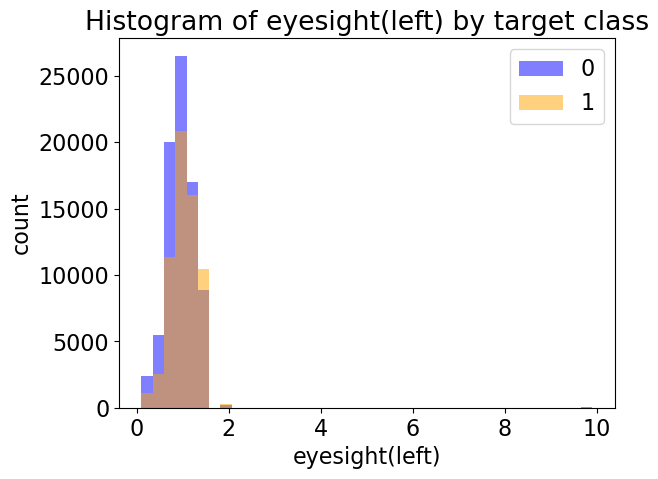

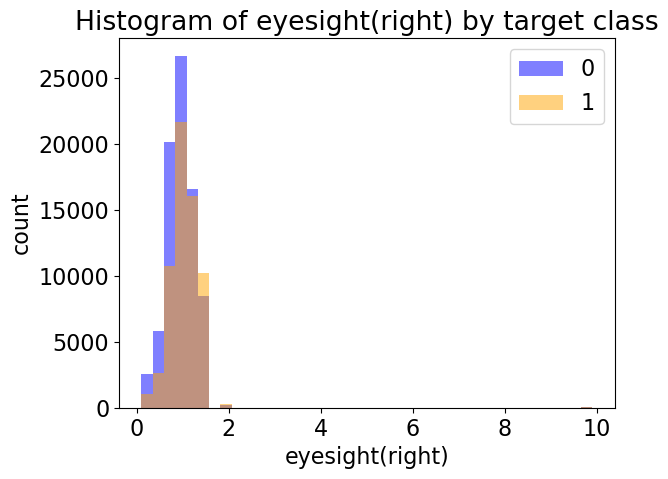

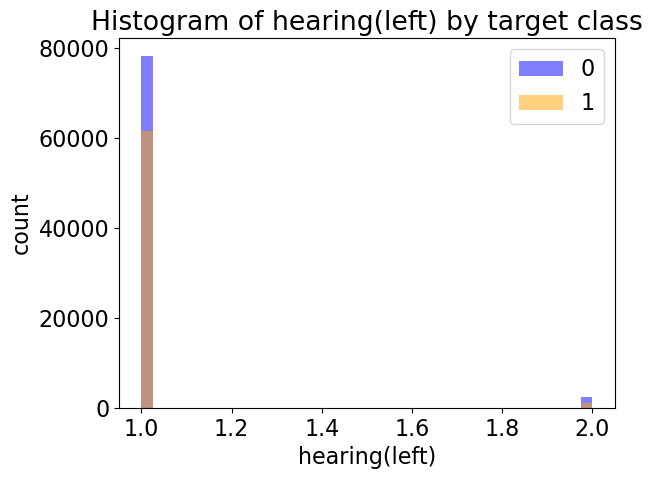

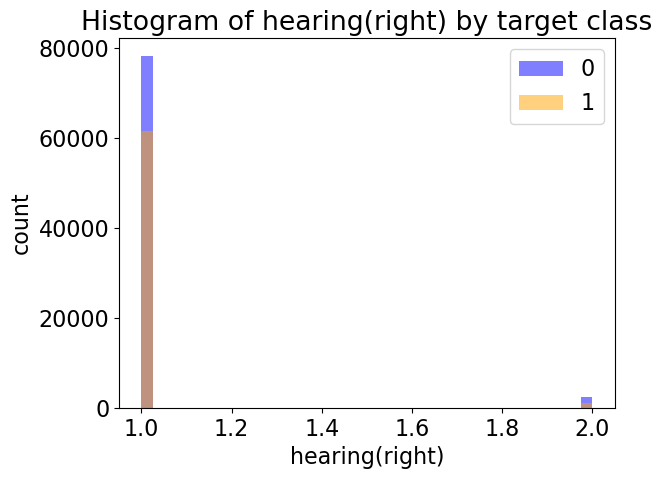

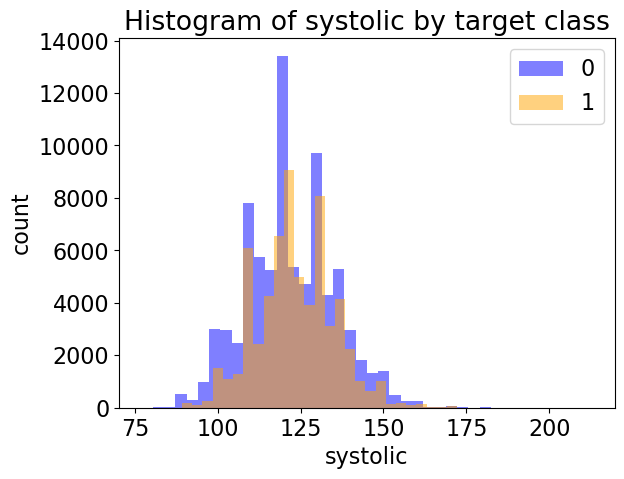

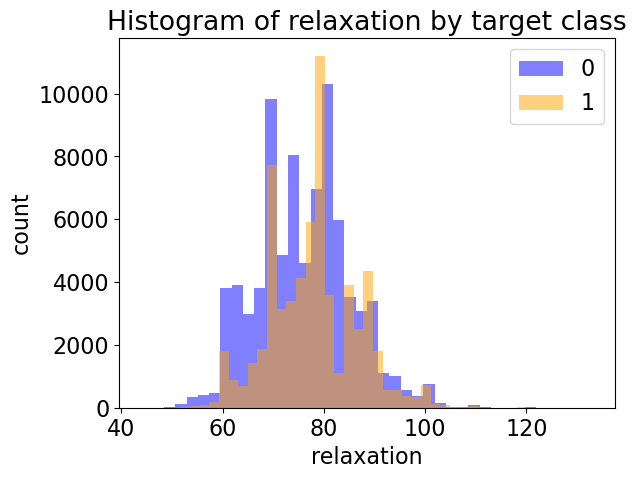

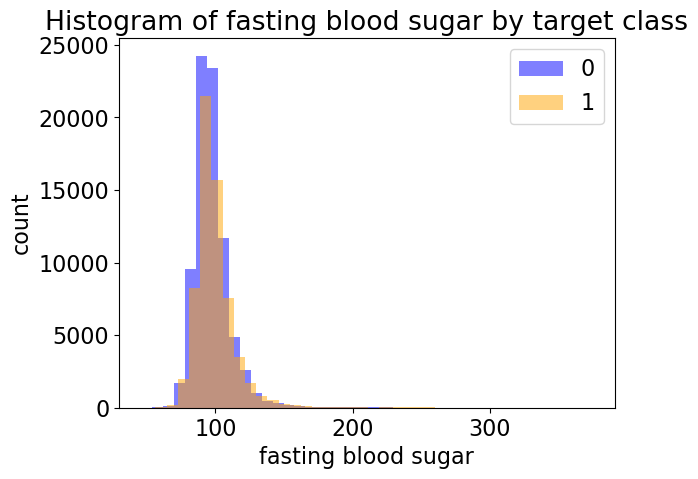

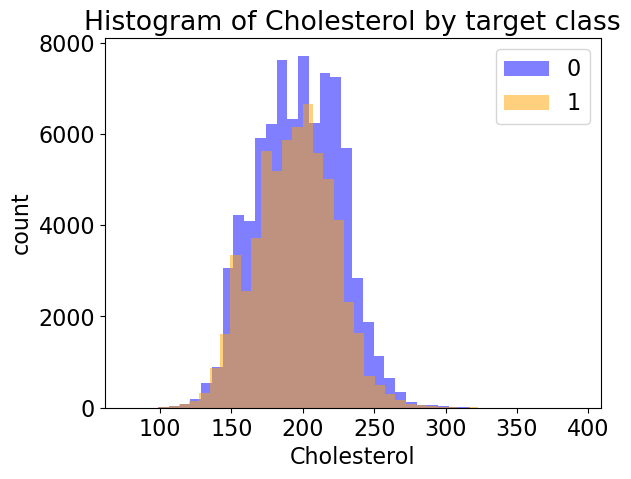

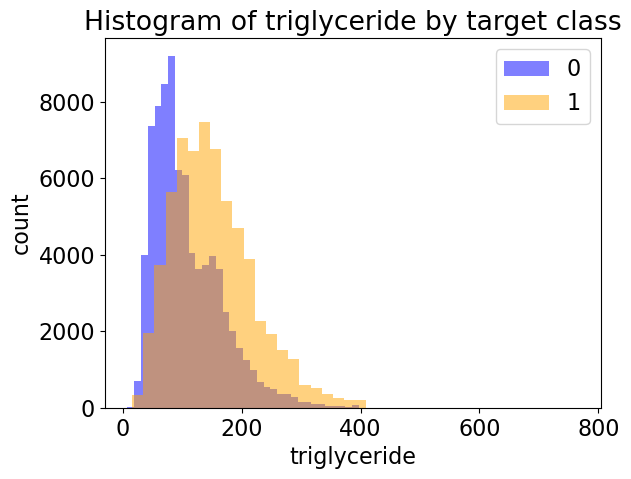

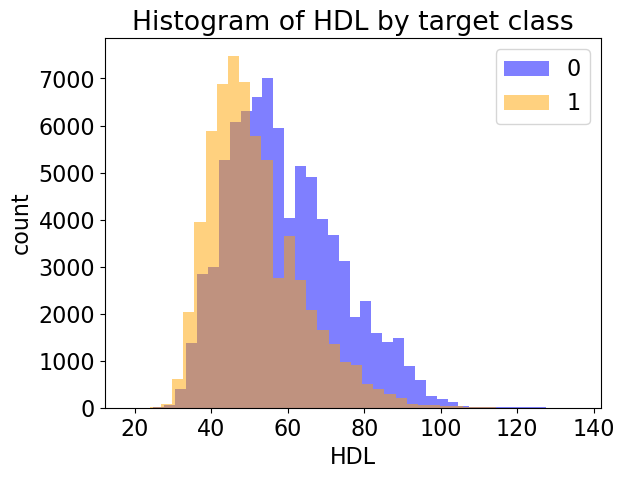

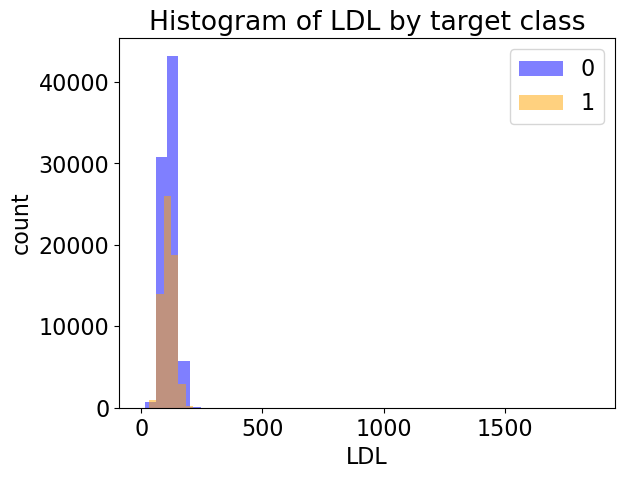

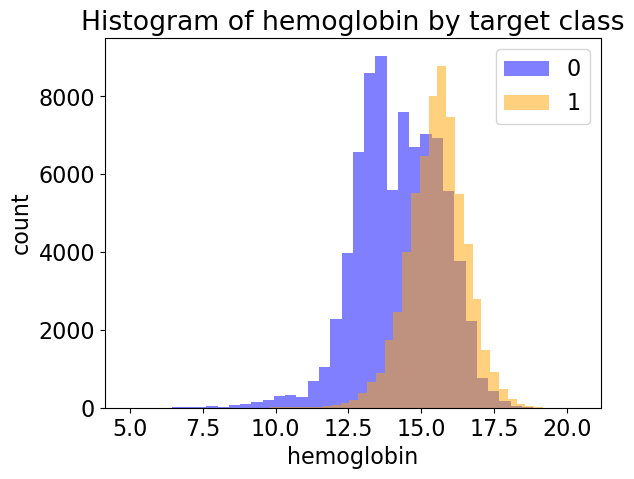

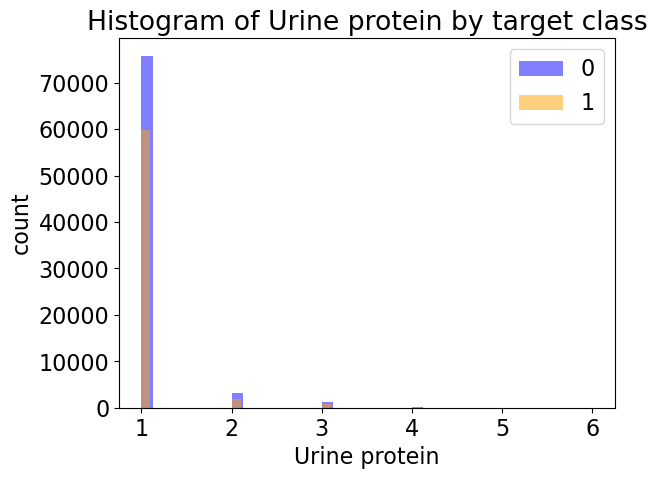

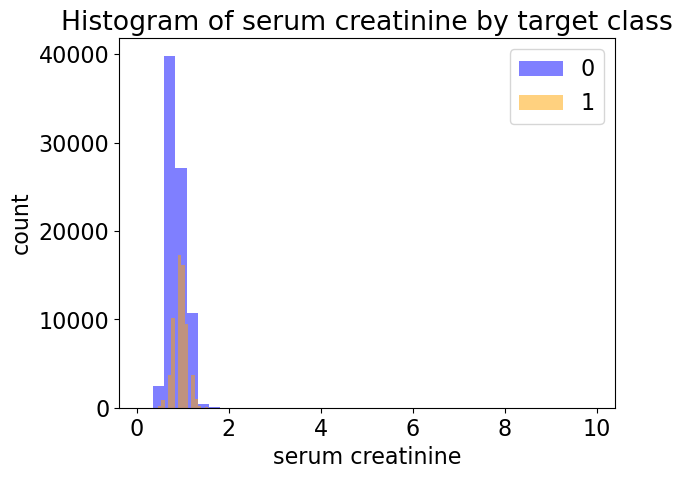

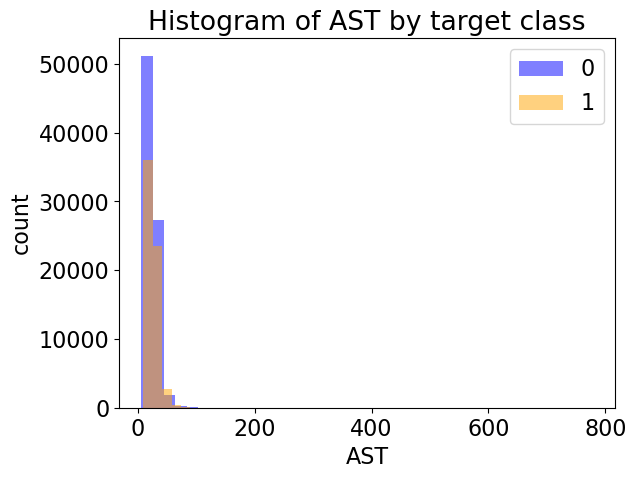

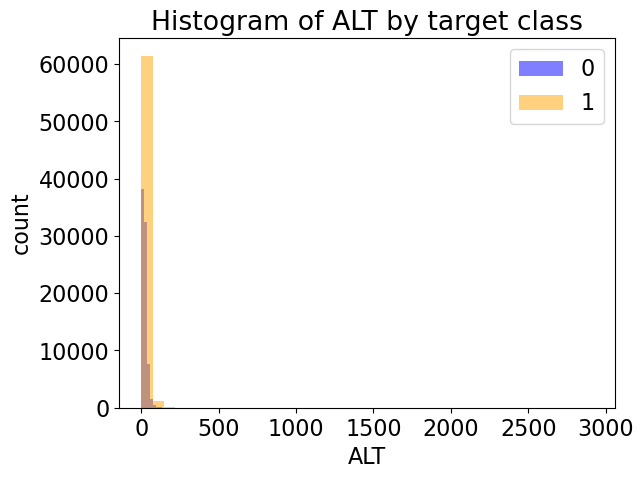

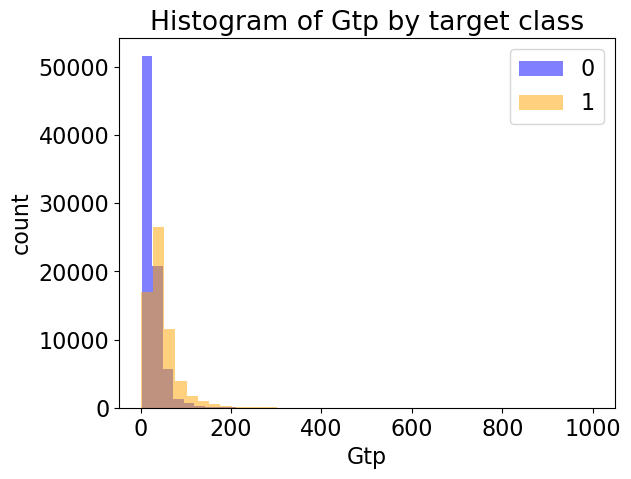

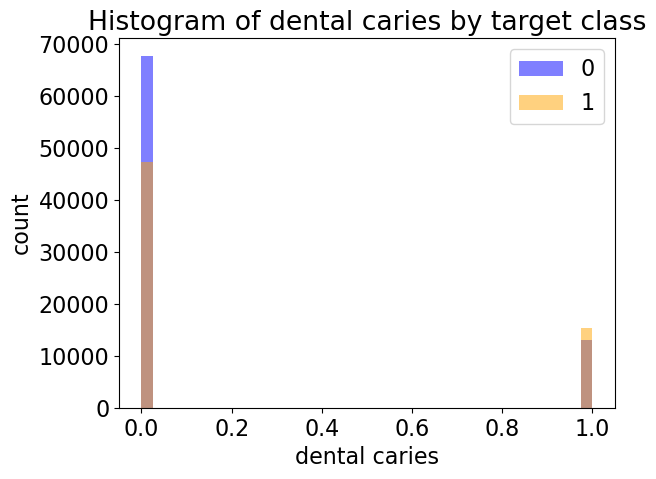

In [5]:
# BEGIN YOUR CODE
positive_examples = train_df.query("smoking == 1")
negative_examples = train_df.query("smoking == 0")
from matplotlib import pyplot as plt
column_names = [
    'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 
    'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic','relaxation','fasting blood sugar','Cholesterol','triglyceride',  
    'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 
    'AST', 'ALT', 'Gtp', 'dental caries'
]

for i in range(1, 23):
    counts, bins, _ = plt.hist(negative_examples.iloc[:,i], bins=40, edgecolor='none',alpha=0.5, color='blue',label='0')
    counts, bins, _ = plt.hist(positive_examples.iloc[:,i], bins=40, edgecolor='none',alpha=0.5, color='orange',label='1')
    
    plt.ylabel('count')

    plt.xlabel(column_names[i-1])
    plt.title(f'Histogram of {column_names[i-1]} by target class')
        

    plt.legend()
    plt.show()
# END YOUR CODE


# Preprocessing

- All the data is numerical features
- The dental cares is binary features. So no transformation is applied
- The hearing(left), hearing(right), are also binary features. Both the data are almost same. So one is dropped and the other is passthrough.  Similarlly, eyesight(left), eyesight(right) data is numerical features and there is no much difference in their data, so one is dropped and other is passthrough.
- The column "id" is dropped because it does not add any value to the target value.
- The rest all columns are numerical features and standard scalar is applied.

In [6]:
numeric_features = []
categorical_features = []
ordinal_features = []
binary_features = []
drop_features = []  # do not include these features in modeling
passthrough_features = []  # do not apply any transformation

# Example: numeric_features = ["age"]
# BEGIN YOUR CODE
numeric_features = ["age", "height(cm)", "weight(kg)", "waist(cm)", 
    "systolic","relaxation","fasting blood sugar","Cholesterol","triglyceride", 
    "HDL", "LDL", "hemoglobin", "serum creatinine", "AST", "ALT","Gtp"]

drop_features = ["id","eyesight(right)","hearing(left)"]
passthrough_features = ["eyesight(left)","hearing(right)","Urine protein","dental caries"] 
#binary_features = ["dental caries"]
# END YOUR CODE

target = "smoking"

In [7]:
X_train, y_train = train_df.drop(columns=["smoking"]), train_df["smoking"]
X_test= test_df

In [8]:
X_valid, y_valid = valid_df.drop(columns=["smoking"]), valid_df["smoking"]
X_train_big, y_train_big=df.drop(columns=["smoking"]), valid_df["smoking"]

In [9]:
preprocessor  = make_column_transformer(
    (StandardScaler(),
    numeric_features), ("drop", drop_features),("passthrough", passthrough_features))
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'height(cm)', 'weight(kg)',
                                  'waist(cm)', 'systolic', 'relaxation',
                                  'fasting blood sugar', 'Cholesterol',
                                  'triglyceride', 'HDL', 'LDL', 'hemoglobin',
                                  'serum creatinine', 'AST', 'ALT', 'Gtp']),
                                ('drop', 'drop',
                                 ['id', 'eyesight(right)', 'hearing(left)']),
                                ('passthrough', 'passthrough',
                                 ['eyesight(left)', 'hearing(right)',
                                  'Urine protein', 'dental caries'])])

# 1. Dummy Classifier

In [10]:
from sklearn.dummy import DummyClassifier


pipeline_Dummy = make_pipeline(preprocessor,DummyClassifier(strategy="prior"))

results = {}
auc_res = {}
results["Dummy"] = cmle.mean_std_cross_val_scores(pipeline_Dummy, X_train, y_train, cv=5,scoring='roc_auc',return_train_score=True,)
pipeline_Dummy.fit(X_train,y_train)
y_predict = pipeline_Dummy.predict_proba(X_test)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.142 (+/- 0.004),0.032 (+/- 0.002),0.500 (+/- 0.000),0.500 (+/- 0.000)


In [11]:
id_column = pd.DataFrame(X_test["id"], columns=["id"])
y_predict_column = pd.DataFrame(y_predict[:,1], columns=["smoking"])

result_df = pd.concat([id_column, y_predict_column], axis=1)

# Save to a CSV file
result_df.to_csv('Dummy.csv', index=False)

### Kaggle Score for Dummy classifier 

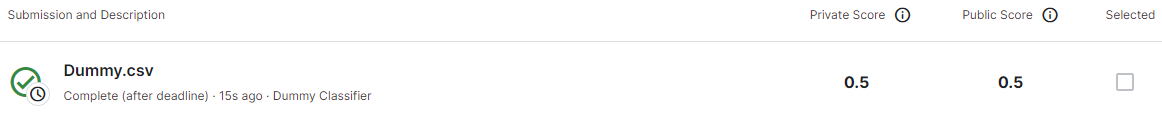

# 2. Decision Tree

In [12]:
from sklearn.model_selection import cross_val_score
# Decision Tree pipeline
pipeline_dt = make_pipeline(preprocessor, DecisionTreeClassifier())

In [13]:
# Calculate cross-validation scores
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline_dt, X_train, y_train, cv=5, scoring='roc_auc')

# Print individual CV scores and mean CV score
print("CV Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

CV Scores: [0.69300759 0.68713851 0.68666429 0.68885125 0.68747809]
Mean CV Score: 0.688627944912356


In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'decisiontreeclassifier__max_depth': [5, 10, 15, 20],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4]
}

# Setup the GridSearchCV object
grid_search = GridSearchCV(pipeline_dt, param_grid, cv=5, scoring='roc_auc',return_train_score=True, )

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'waist(cm)',
                                                                          'systolic',
                                                                          'relaxation',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          'Cholesterol',
                                                                          'triglyceride',
                                                                          'HDL',
                                                                          'LDL',
                                                                          'hemoglobin',
                                                                          'serum '
                                                                          'creatinine',
                                                                          'AST',
                                                                          'ALT',
                                                                          'Gtp']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['id',
                                                                          'eyesight(...
                                                                         'passthrough',
                                                                         ['eyesight(left)',
                                                                          'hearing(right)',
                                                                          'Urine '
                                                                          'protein',
                                                                          'dental '
                                                                          'caries'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__max_depth': [5, 10, 15, 20],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
                         'decisiontreeclassifier__min_samples_split': [2, 5,
                                                                       10]},
             return_train_score=True, scoring='roc_auc')

In [15]:
print("DecisionTree")
print(f"Best Score: {grid_search.best_score_}")
print(f"Best Parameters: {grid_search.best_params_}")

DecisionTree
Best Score: 0.831665185238332
Best Parameters: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 2}


In [16]:
best_model = grid_search.best_estimator_
results["Decision_Tree"] = cmle.mean_std_cross_val_scores(best_model, X_train, y_train, cv=5,scoring='roc_auc',return_train_score=True,)
y_predict = best_model.predict_proba(X_test)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.142 (+/- 0.004),0.032 (+/- 0.002),0.500 (+/- 0.000),0.500 (+/- 0.000)
Decision_Tree,1.596 (+/- 0.003),0.040 (+/- 0.000),0.832 (+/- 0.002),0.865 (+/- 0.001)


### Receiver Operating Characteristic (ROC) curve

- Another commonly used tool to analyze the behavior of classifiers at different thresholds.
- Similar to the PR curve, it considers all possible thresholds for a given classifier given by `predict_proba` but instead of precision and recall it plots false positive rate (FPR) and true positive rate (TPR or recall).
$$ FPR  = \frac{FP}{FP + TN}, TPR = \frac{TP}{TP + FP}$$

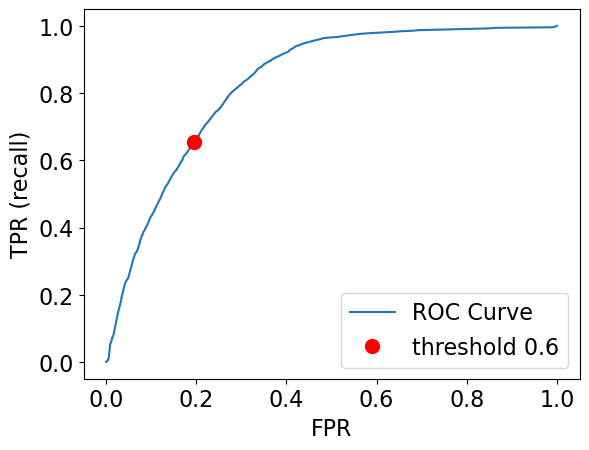

In [17]:
from sklearn.metrics import roc_curve
best_model = grid_search.best_estimator_
fpr, tpr, thresholds = roc_curve(y_valid, best_model.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.6))

plt.plot(fpr[default_threshold], tpr[default_threshold],
         "or", markersize=10, label="threshold 0.6")
plt.legend(loc="best")

### Area under the curve (AUC)

- AUC provides a single meaningful number for the model performance.

In [18]:
from sklearn.metrics import roc_auc_score

auc_dt = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])
auc_res["Decision Tree"] = auc_dt
print("AUC for Decision Tree classifier : {:.3f}".format(auc_dt))

AUC for Decision Tree classifier : 0.832


In [19]:
id_column = pd.DataFrame(X_test["id"], columns=["id"])
y_predict_column = pd.DataFrame(y_predict[:,1], columns=["smoking"])

result_df = pd.concat([id_column, y_predict_column], axis=1)

# Save to a CSV file
result_df.to_csv('decision Tree classifier.csv', index=False)

### Kaggle Score

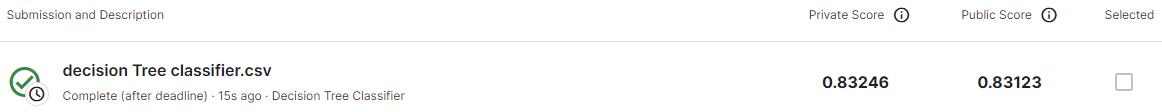

# 3. KNN Model

In [20]:
# Creating the Pipeline
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())
pipe_knn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'height(cm)',
                                                   'weight(kg)', 'waist(cm)',
                                                   'systolic', 'relaxation',
                                                   'fasting blood sugar',
                                                   'Cholesterol',
                                                   'triglyceride', 'HDL', 'LDL',
                                                   'hemoglobin',
                                                   'serum creatinine', 'AST',
                                                   'ALT', 'Gtp']),
                                                 ('drop', 'drop',
                                                  ['id', 'eyesight(right)',
                                                   'hearing(left)']),
                                                 ('passthrough', 'passthrough',
                                                  ['eyesight(left)',
                                                   'hearing(right)',
                                                   'Urine protein',
                                                   'dental caries'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [21]:
# Hyperparameter Tuning
param_grid_knn = {
    "kneighborsclassifier__n_neighbors": range(60, 70)
}
grid_search_knn= GridSearchCV(pipe_knn, param_grid_knn, cv=5,n_jobs=-1,scoring='roc_auc',return_train_score=True, )
grid_search_knn.fit(X_train, y_train)  # all the work is done here
grid_search_knn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'waist(cm)',
                                                                          'systolic',
                                                                          'relaxation',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          'Cholesterol',
                                                                          'triglyceride',
                                                                          'HDL',
                                                                          'LDL',
                                                                          'hemoglobin',
                                                                          'serum '
                                                                          'creatinine',
                                                                          'AST',
                                                                          'ALT',
                                                                          'Gtp']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['id',
                                                                          'eyesight(right)',
                                                                          'hearing(left)']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['eyesight(left)',
                                                                          'hearing(right)',
                                                                          'Urine '
                                                                          'protein',
                                                                          'dental '
                                                                          'caries'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(60, 70)},
             return_train_score=True, scoring='roc_auc')

In [22]:
print("KNN:")
print(f"Best Score: {grid_search_knn.best_score_}")
print(f"Best Parameters: {grid_search_knn.best_params_}")

KNN:
Best Score: 0.8439295603854046
Best Parameters: {'kneighborsclassifier__n_neighbors': 69}


In [23]:
# Evaluating the Model
pipe_bestknn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=69))
pipe_bestknn.fit(X_train,y_train)
results["KNN"] = cmle.mean_std_cross_val_scores(pipe_bestknn, X_train, y_train, cv=5,scoring='roc_auc',return_train_score=True,)
y_predict = pipe_bestknn.predict_proba(X_test)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.142 (+/- 0.004),0.032 (+/- 0.002),0.500 (+/- 0.000),0.500 (+/- 0.000)
Decision_Tree,1.596 (+/- 0.003),0.040 (+/- 0.000),0.832 (+/- 0.002),0.865 (+/- 0.001)
KNN,0.165 (+/- 0.013),7.141 (+/- 0.285),0.844 (+/- 0.001),0.856 (+/- 0.000)


### Receiver Operating Characteristic (ROC) curve

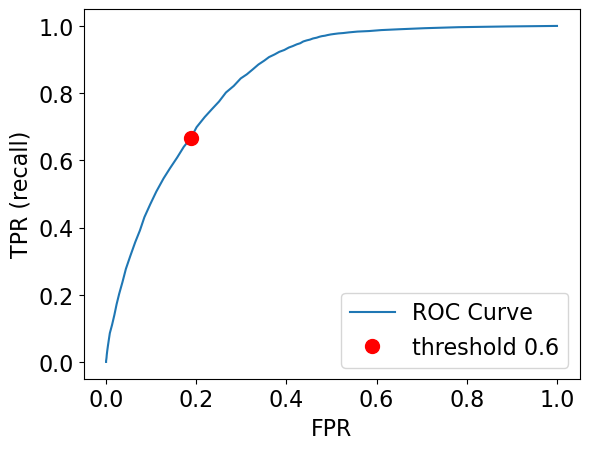

In [24]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid, pipe_bestknn.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.6))

plt.plot(fpr[default_threshold], tpr[default_threshold],
         "or", markersize=10, label="threshold 0.6")
plt.legend(loc="best")

### Area under the curve (AUC)

In [25]:
# Highlighting Default Threshold
from sklearn.metrics import roc_auc_score
auc_knn = roc_auc_score(y_valid, pipe_bestknn.predict_proba(X_valid)[:, 1])
auc_res["KNN"] = auc_knn
print("AUC for KNN classifier: {:.3f}".format(auc_knn))

AUC for KNN classifier: 0.846


In [26]:
print(X_train.shape)
print(X_test.shape)

(143330, 23)
(106171, 23)


### Code for creating csv

In [27]:
id_column = pd.DataFrame(X_test["id"], columns=["id"])
y_predict_column = pd.DataFrame(y_predict[:,1], columns=["smoking"])

result_df = pd.concat([id_column, y_predict_column], axis=1)

# Save to a CSV file
result_df.to_csv('KNN_with_all_features.csv', index=False)

### Kaggle Score

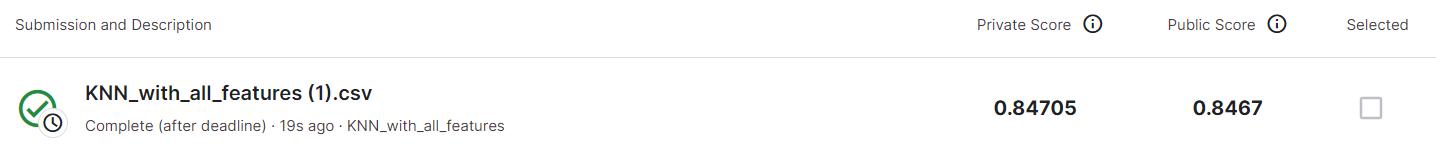

# 4. Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression, Ridge
pipeline_lr = make_pipeline(preprocessor,LogisticRegression(class_weight="balanced"))
pipeline_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'height(cm)',
                                                   'weight(kg)', 'waist(cm)',
                                                   'systolic', 'relaxation',
                                                   'fasting blood sugar',
                                                   'Cholesterol',
                                                   'triglyceride', 'HDL', 'LDL',
                                                   'hemoglobin',
                                                   'serum creatinine', 'AST',
                                                   'ALT', 'Gtp']),
                                                 ('drop', 'drop',
                                                  ['id', 'eyesight(right)',
                                                   'hearing(left)']),
                                                 ('passthrough', 'passthrough',
                                                  ['eyesight(left)',
                                                   'hearing(right)',
                                                   'Urine protein',
                                                   'dental caries'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [29]:
# Hyper Parameter Tuning
C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)
param_grid_lr = {'logisticregression__C': C_vals,
             }


grid_search_lr= GridSearchCV(pipeline_lr, param_grid_lr, cv=5,n_jobs=-1,scoring='roc_auc',return_train_score=True, )
grid_search_lr.fit(X_train, y_train)  # all the work is done here
grid_search_lr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'waist(cm)',
                                                                          'systolic',
                                                                          'relaxation',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          'Cholesterol',
                                                                          'triglyceride',
                                                                          'HDL',
                                                                          'LDL',
                                                                          'hemoglobin',
                                                                          'serum '
                                                                          'creatinine',
                                                                          'AST',
                                                                          'ALT',
                                                                          'Gtp']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['id',
                                                                          'eyesight(right)',
                                                                          'hearing(left)']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['eyesight(left)',
                                                                          'hearing(right)',
                                                                          'Urine '
                                                                          'protein',
                                                                          'dental '
                                                                          'caries'])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([ 0.03162278,  0.1       ,  0.31622777,  1.        ,  3.16227766,
       10.        , 31.6227766 ])},
             return_train_score=True, scoring='roc_auc')

In [30]:
print("Logistic_Regression:")
print(f"Best Score: {grid_search_lr.best_score_}")
print(f"Best Parameters: {grid_search_lr.best_params_}")

Logistic_Regression:
Best Score: 0.8341508616667644
Best Parameters: {'logisticregression__C': 31.622776601683793}


In [31]:
pipe_bestlr = make_pipeline(preprocessor, LogisticRegression(C=31.62277,class_weight="balanced"))
pipe_bestlr.fit(X_train,y_train)
# Calculate cross-validation scores with hyperparameter tuning

results["Logistic Regression"] = cmle.mean_std_cross_val_scores(pipe_bestlr, X_train, y_train, cv=5,scoring='roc_auc',return_train_score=True,)
y_predict = pipe_bestlr.predict_proba(X_test)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.142 (+/- 0.004),0.032 (+/- 0.002),0.500 (+/- 0.000),0.500 (+/- 0.000)
Decision_Tree,1.596 (+/- 0.003),0.040 (+/- 0.000),0.832 (+/- 0.002),0.865 (+/- 0.001)
KNN,0.165 (+/- 0.013),7.141 (+/- 0.285),0.844 (+/- 0.001),0.856 (+/- 0.000)
Logistic Regression,1.006 (+/- 0.059),0.039 (+/- 0.004),0.834 (+/- 0.001),0.834 (+/- 0.000)


### Receiver Operating Characteristic (ROC) curve

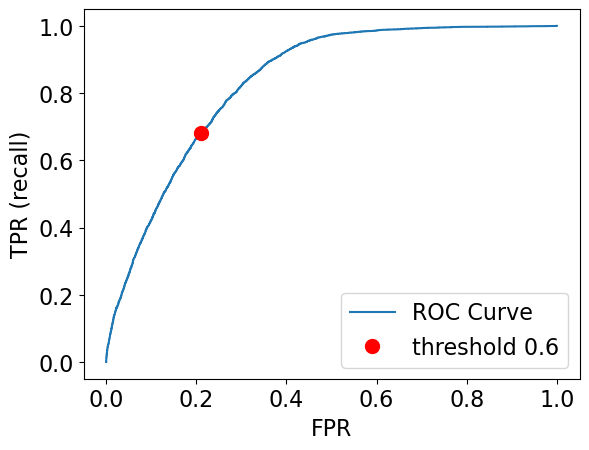

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, pipe_bestlr.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.6))

plt.plot(fpr[default_threshold], tpr[default_threshold],
         "or", markersize=10, label="threshold 0.6")
plt.legend(loc="best")

In [33]:
from sklearn.metrics import roc_auc_score

auc_lr = roc_auc_score(y_valid, pipe_bestlr.predict_proba(X_valid)[:, 1])
auc_res["Logistic Regression"] = auc_lr
print("AUC for Logistic Regression classifier: {:.3f}".format(auc_lr))

AUC for Logistic Regression classifier: 0.834


In [34]:

id_column = pd.DataFrame(X_test["id"], columns=["id"])
y_predict_column = pd.DataFrame(y_predict[:,1], columns=["smoking"])

result_df = pd.concat([id_column, y_predict_column], axis=1)

# Save to a CSV file
result_df.to_csv('Logistic_Regression.csv', index=False)

### Kaggle Score

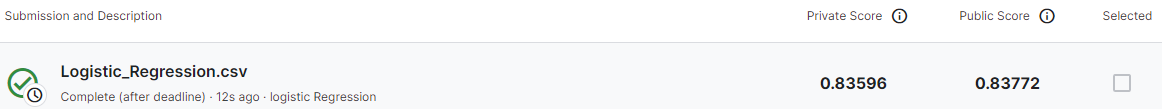

# 5. Linear SVC Model 

In [35]:
from sklearn.svm import LinearSVC

from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
pipe_linearsvc = make_pipeline(preprocessor, LinearSVC(dual = True,class_weight="balanced"))
param_grid_linearsvc = {
    "linearsvc__max_iter": [1000,1500],
    "linearsvc__C": [0.1,0.316,1.0,3.16],
}
grid_search_linearsvc= GridSearchCV(pipe_linearsvc, param_grid_linearsvc, cv=5,scoring="roc_auc", return_train_score=True)
grid_search_linearsvc.fit(X_train, y_train)  # all the work is done here
grid_search_linearsvc

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'waist(cm)',
                                                                          'systolic',
                                                                          'relaxation',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          'Cholesterol',
                                                                          'triglyceride',
                                                                          'HDL',
                                                                          'LDL',
                                                                          'hemoglobin',
                                                                          'serum '
                                                                          'creatinine',
                                                                          'AST',
                                                                          'ALT',
                                                                          'Gtp']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['id',
                                                                          'eyesight(right)',
                                                                          'hearing(left)']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['eyesight(left)',
                                                                          'hearing(right)',
                                                                          'Urine '
                                                                          'protein',
                                                                          'dental '
                                                                          'caries'])])),
                                       ('linearsvc',
                                        LinearSVC(class_weight='balanced'))]),
             param_grid={'linearsvc__C': [0.1, 0.316, 1.0, 3.16],
                         'linearsvc__max_iter': [1000, 1500]},
             return_train_score=True, scoring='roc_auc')

In [36]:
print("LinearSVC:")
print(f"Best Score: {grid_search_linearsvc.best_score_}")
print(f"Best Parameters: {grid_search_linearsvc.best_params_}")
#best_model_svc = grid_search_linearsvc.best_estimator_

LinearSVC:
Best Score: 0.8335736762338163
Best Parameters: {'linearsvc__C': 3.16, 'linearsvc__max_iter': 1000}


In [37]:
pipe_bestlinearsvc = make_pipeline(preprocessor, LinearSVC(C=3.16,max_iter=1000,dual = True,class_weight="balanced"))
pipe_bestlinearsvc.fit(X_train,y_train)
# Calculate cross-validation scores with hyperparameter tuning
results["Linear_svc"] = cmle.mean_std_cross_val_scores(pipe_bestlinearsvc, X_train, y_train,scoring="roc_auc", cv=5,return_train_score=True)

In [38]:
y_predict = pipe_bestlinearsvc.predict(X_test)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.142 (+/- 0.004),0.032 (+/- 0.002),0.500 (+/- 0.000),0.500 (+/- 0.000)
Decision_Tree,1.596 (+/- 0.003),0.040 (+/- 0.000),0.832 (+/- 0.002),0.865 (+/- 0.001)
KNN,0.165 (+/- 0.013),7.141 (+/- 0.285),0.844 (+/- 0.001),0.856 (+/- 0.000)
Logistic Regression,1.006 (+/- 0.059),0.039 (+/- 0.004),0.834 (+/- 0.001),0.834 (+/- 0.000)
Linear_svc,58.046 (+/- 1.097),0.055 (+/- 0.022),0.834 (+/- 0.001),0.834 (+/- 0.000)


In [39]:
print(X_train.shape)
print(X_test.shape)
#y_score =pipeline.score(X_test,y_test)

(143330, 23)
(106171, 23)


- As probability prediction is not there in Linear SVC, we cannot determine area under the curve. Similarrly , the output file generated is in binary instead of the probablity, so this model will have least accuracy in the non-dummy models which is seen in the kaggle score shown below.

In [40]:

id_column = pd.DataFrame(X_test["id"], columns=["id"])
y_predict_column = pd.DataFrame(y_predict, columns=["smoking"])

result_df = pd.concat([id_column, y_predict_column], axis=1)

# Save to a CSV file
result_df.to_csv('linearsvc_predictions_ROC.csv', index=False)

### Kaggle Score for  Linear SVC

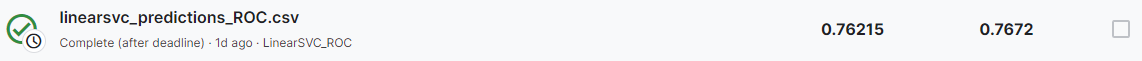

# 6. Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
# Update the pipeline to use Random Forest instead of Decision Tree
pipeline_rf = make_pipeline(preprocessor, RandomForestClassifier())

In [42]:
# Calculate cross-validation scores
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='roc_auc')

# Print individual CV scores and mean CV score
print("CV Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

CV Scores: [0.85580907 0.85735786 0.854224   0.85560073 0.85824939]
Mean CV Score: 0.8562482083747159


In [43]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'randomforestclassifier__n_estimators': [100,50], 
    'randomforestclassifier__max_depth': [5,10,15], 
    'randomforestclassifier__min_samples_split': [1,2],
    'randomforestclassifier__min_samples_leaf': [1,2],
    'randomforestclassifier__class_weight': ['balanced']
}

# Setup the GridSearchCV object
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='roc_auc',return_train_score=True, )

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'waist(cm)',
                                                                          'systolic',
                                                                          'relaxation',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          'Cholesterol',
                                                                          'triglyceride',
                                                                          'HDL',
                                                                          'LDL',
                                                                          'hemoglobin',
                                                                          'serum '
                                                                          'creatinine',
                                                                          'AST',
                                                                          'ALT',
                                                                          'Gtp']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['id',
                                                                          'eyesight(...
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__class_weight': ['balanced'],
                         'randomforestclassifier__max_depth': [5, 10, 15],
                         'randomforestclassifier__min_samples_leaf': [1, 2],
                         'randomforestclassifier__min_samples_split': [1, 2],
                         'randomforestclassifier__n_estimators': [100, 50]},
             return_train_score=True, scoring='roc_auc')

In [44]:
print("Random forest:")
print(f"Best Score: {grid_search.best_score_}")
print(f"Best Parameters: {grid_search.best_params_}")

Random forest:
Best Score: 0.8579385366151022
Best Parameters: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}


In [45]:
best_model = grid_search.best_estimator_
results["Random_Forest"] = cmle.mean_std_cross_val_scores(best_model, X_train, y_train, cv=5,scoring='roc_auc',return_train_score=True,)
y_predict = best_model.predict_proba(X_test)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.142 (+/- 0.004),0.032 (+/- 0.002),0.500 (+/- 0.000),0.500 (+/- 0.000)
Decision_Tree,1.596 (+/- 0.003),0.040 (+/- 0.000),0.832 (+/- 0.002),0.865 (+/- 0.001)
KNN,0.165 (+/- 0.013),7.141 (+/- 0.285),0.844 (+/- 0.001),0.856 (+/- 0.000)
Logistic Regression,1.006 (+/- 0.059),0.039 (+/- 0.004),0.834 (+/- 0.001),0.834 (+/- 0.000)
Linear_svc,58.046 (+/- 1.097),0.055 (+/- 0.022),0.834 (+/- 0.001),0.834 (+/- 0.000)
Random_Forest,37.875 (+/- 0.597),0.861 (+/- 0.020),0.858 (+/- 0.002),0.941 (+/- 0.001)


### Receiver Operating Characteristic (ROC) curve

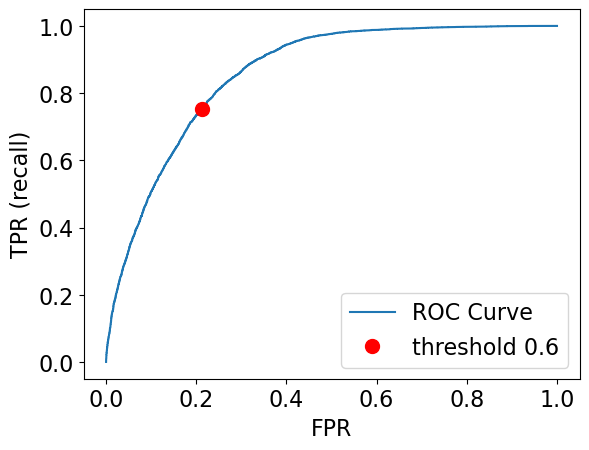

In [46]:
from sklearn.metrics import roc_curve
best_model = grid_search.best_estimator_
fpr, tpr, thresholds = roc_curve(y_valid, best_model.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.6))

plt.plot(fpr[default_threshold], tpr[default_threshold],
         "or", markersize=10, label="threshold 0.6")
plt.legend(loc="best")

In [47]:
from sklearn.metrics import roc_auc_score

auc_rf = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])
auc_res["Random Forest"] = auc_rf
print("AUC Random Forest classifier: {:.3f}".format(auc_rf))

AUC Random Forest classifier: 0.859


In [48]:
id_column = pd.DataFrame(X_test["id"], columns=["id"])
y_predict_column = pd.DataFrame(y_predict[:,1], columns=["smoking"])

result_df = pd.concat([id_column, y_predict_column], axis=1)

# Save to a CSV file
result_df.to_csv('Random_forset_final.csv', index=False)

### Kaggle Score

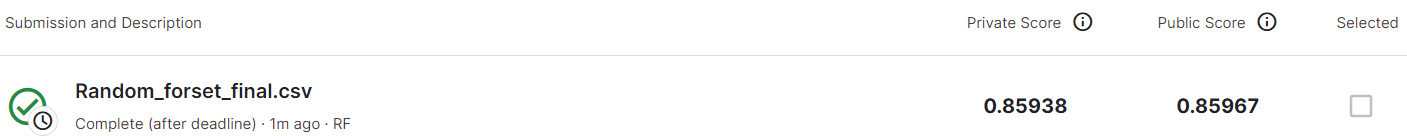

# 7. XGBOOST

In [49]:
import xgboost as xgb
xgboost_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

pipeline_Xg = make_pipeline(preprocessor,xgboost_classifier)
pipeline_Xg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'height(cm)',
                                                   'weight(kg)', 'waist(cm)',
                                                   'systolic', 'relaxation',
                                                   'fasting blood sugar',
                                                   'Cholesterol',
                                                   'triglyceride', 'HDL', 'LDL',
                                                   'hemoglobin',
                                                   'serum creatinine', 'AST',
                                                   'ALT', 'Gtp']),
                                                 ('drop', 'drop',
                                                  ['id', 'eyesight(right)',
                                                   'hearing(left)']),
                                                 ('passth...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [50]:
# Hyper Parameter Tuning
param_grid_xgboost = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__max_depth': [3, 4, 5],
    'xgbclassifier__n_estimators': [50,150,250]
}


grid_search_Xg= GridSearchCV(pipeline_Xg, param_grid_xgboost, cv=5,n_jobs=-1,scoring='roc_auc',return_train_score=True )
grid_search_Xg.fit(X_train, y_train)  # all the work is done here
grid_search_Xg

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'waist(cm)',
                                                                          'systolic',
                                                                          'relaxation',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          'Cholesterol',
                                                                          'triglyceride',
                                                                          'HDL',
                                                                          'LDL',
                                                                          'hemoglobin',
                                                                          'serum '
                                                                          'creatinine',
                                                                          'AST',
                                                                          'ALT',
                                                                          'Gtp']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['id',
                                                                          'eyesight(...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgbclassifier__max_depth': [3, 4, 5],
                         'xgbclassifier__n_estimators': [50, 150, 250]},
             return_train_score=True, scoring='roc_auc')

In [51]:
print("Xgboost:")
print(f"Best Score: {grid_search_Xg.best_score_}")
print(f"Best Parameters: {grid_search_Xg.best_params_}")

Xgboost:
Best Score: 0.8669699861612676
Best Parameters: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 250}


In [52]:
xgboost_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)


pipe_bestXg = make_pipeline(preprocessor, xgboost_classifier)


pipe_bestXg.set_params(xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=250)
pipe_bestXg.fit(X_train,y_train)
# Calculate cross-validation scores with hyperparameter tuning

results["XGboost"] = cmle.mean_std_cross_val_scores(pipe_bestXg, X_train, y_train, cv=5,scoring='roc_auc',return_train_score=True,)
y_predict = pipe_bestXg.predict_proba(X_test)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.142 (+/- 0.004),0.032 (+/- 0.002),0.500 (+/- 0.000),0.500 (+/- 0.000)
Decision_Tree,1.596 (+/- 0.003),0.040 (+/- 0.000),0.832 (+/- 0.002),0.865 (+/- 0.001)
KNN,0.165 (+/- 0.013),7.141 (+/- 0.285),0.844 (+/- 0.001),0.856 (+/- 0.000)
Logistic Regression,1.006 (+/- 0.059),0.039 (+/- 0.004),0.834 (+/- 0.001),0.834 (+/- 0.000)
Linear_svc,58.046 (+/- 1.097),0.055 (+/- 0.022),0.834 (+/- 0.001),0.834 (+/- 0.000)
Random_Forest,37.875 (+/- 0.597),0.861 (+/- 0.020),0.858 (+/- 0.002),0.941 (+/- 0.001)
XGboost,11.852 (+/- 0.196),0.082 (+/- 0.011),0.867 (+/- 0.002),0.888 (+/- 0.001)


### Receiver Operating Characteristic (ROC) curve

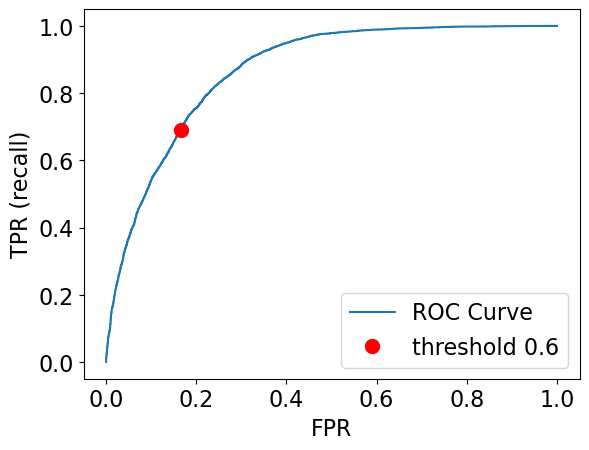

In [53]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, pipe_bestXg.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.6))

plt.plot(fpr[default_threshold], tpr[default_threshold],
         "or", markersize=10, label="threshold 0.6")
plt.legend(loc="best")

In [54]:
from sklearn.metrics import roc_auc_score

auc_xgb = roc_auc_score(y_valid, pipe_bestXg.predict_proba(X_valid)[:, 1])
auc_res["XGB"] = auc_xgb
print("AUC for Xgboost: {:.3f}".format(auc_xgb))

AUC for Xgboost: 0.868


In [55]:
id_column = pd.DataFrame(X_test["id"], columns=["id"])
y_predict_column = pd.DataFrame(y_predict[:,1], columns=["smoking"])

result_df = pd.concat([id_column, y_predict_column], axis=1)

# Save to a CSV file
result_df.to_csv('Xgboost.csv', index=False)

### Kaggle Score

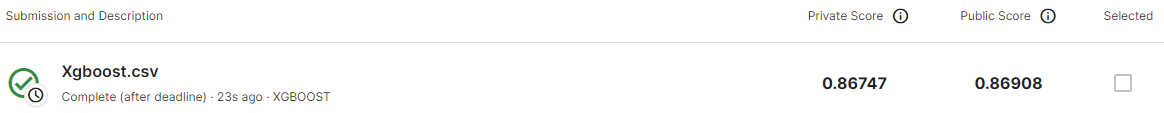

# 8. Hist Gradient Boosting Classifier Starts here !


In [56]:
from sklearn.ensemble import HistGradientBoostingClassifier
pipe_hist = make_pipeline(preprocessor, HistGradientBoostingClassifier(random_state=123,class_weight="balanced",l2_regularization=1.5))
#pipe_hist = make_pipeline(preprocessor, HistGradientBoostingClassifier(random_state=123,l2_regularization=1.5))
#pipe_rf = make_pipeline(preprocessor, HistGradientBoostingClassifier(random_state=123,class_weight='balanced'))
pipe_hist

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'height(cm)',
                                                   'weight(kg)', 'waist(cm)',
                                                   'systolic', 'relaxation',
                                                   'fasting blood sugar',
                                                   'Cholesterol',
                                                   'triglyceride', 'HDL', 'LDL',
                                                   'hemoglobin',
                                                   'serum creatinine', 'AST',
                                                   'ALT', 'Gtp']),
                                                 ('drop', 'drop',
                                                  ['id', 'eyesight(right)',
                                                   'hearing(left)']),
                                                 ('passthrough', 'passthrough',
                                                  ['eyesight(left)',
                                                   'hearing(right)',
                                                   'Urine protein',
                                                   'dental caries'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=1.5,
                                                random_state=123))])

In [57]:
#param_grid_hist = {
#"histgradientboostingclassifier__learning_rate": (0.05,0.1,0.15,0.2),
#    "histgradientboostingclassifier__max_leaf_nodes": (10,20,31),
#}
param_grid_hist = {
    "histgradientboostingclassifier__learning_rate" : (0.1,0.15),
    "histgradientboostingclassifier__max_leaf_nodes": (10,31),
}


grid_search_hist= GridSearchCV(pipe_hist, param_grid_hist, cv=5,n_jobs=-1,scoring='roc_auc',return_train_score=True, )
grid_search_hist.fit(X_train, y_train)  # all the work is done here
grid_search_hist


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'waist(cm)',
                                                                          'systolic',
                                                                          'relaxation',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          'Cholesterol',
                                                                          'triglyceride',
                                                                          'HDL',
                                                                          'LDL',
                                                                          'hemoglobin',
                                                                          'serum '
                                                                          'creatinine',
                                                                          'AST',
                                                                          'ALT',
                                                                          'Gtp']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['id',
                                                                          'eyesight(...
                                                                          'Urine '
                                                                          'protein',
                                                                          'dental '
                                                                          'caries'])])),
                                       ('histgradientboostingclassifier',
                                        HistGradientBoostingClassifier(class_weight='balanced',
                                                                       l2_regularization=1.5,
                                                                       random_state=123))]),
             n_jobs=-1,
             param_grid={'histgradientboostingclassifier__learning_rate': (0.1,
                                                                           0.15),
                         'histgradientboostingclassifier__max_leaf_nodes': (10,
                                                                            31)},
             return_train_score=True, scoring='roc_auc')

In [58]:
print("HistGradientBoosting:")
print(f"Best Score: {grid_search_hist.best_score_}")
print(f"Best Parameters: {grid_search_hist.best_params_}")

HistGradientBoosting:
Best Score: 0.8648770274138224
Best Parameters: {'histgradientboostingclassifier__learning_rate': 0.15, 'histgradientboostingclassifier__max_leaf_nodes': 31}


In [59]:
#pipe_besthist = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(random_state=123,class_weight="balanced",learning_rate=0.15,l2_regularization=1.5))
pipe_besthist = make_pipeline(preprocessor, HistGradientBoostingClassifier(random_state=123,class_weight="balanced",learning_rate=0.15,max_leaf_nodes=31,l2_regularization=1.5))
pipe_besthist.fit(X_train,y_train)
# Calculate cross-validation scores with hyperparameter tuning
results["HistGradientBoostingClassifier"] = cmle.mean_std_cross_val_scores(pipe_besthist, X_train, y_train, cv=5,scoring='roc_auc',return_train_score=True,)
y_predict = pipe_besthist.predict_proba(X_test)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.142 (+/- 0.004),0.032 (+/- 0.002),0.500 (+/- 0.000),0.500 (+/- 0.000)
Decision_Tree,1.596 (+/- 0.003),0.040 (+/- 0.000),0.832 (+/- 0.002),0.865 (+/- 0.001)
KNN,0.165 (+/- 0.013),7.141 (+/- 0.285),0.844 (+/- 0.001),0.856 (+/- 0.000)
Logistic Regression,1.006 (+/- 0.059),0.039 (+/- 0.004),0.834 (+/- 0.001),0.834 (+/- 0.000)
Linear_svc,58.046 (+/- 1.097),0.055 (+/- 0.022),0.834 (+/- 0.001),0.834 (+/- 0.000)
Random_Forest,37.875 (+/- 0.597),0.861 (+/- 0.020),0.858 (+/- 0.002),0.941 (+/- 0.001)
XGboost,11.852 (+/- 0.196),0.082 (+/- 0.011),0.867 (+/- 0.002),0.888 (+/- 0.001)
HistGradientBoostingClassifier,2.345 (+/- 0.011),0.114 (+/- 0.002),0.865 (+/- 0.002),0.883 (+/- 0.000)


### Receiver Operating Characteristic (ROC) curve

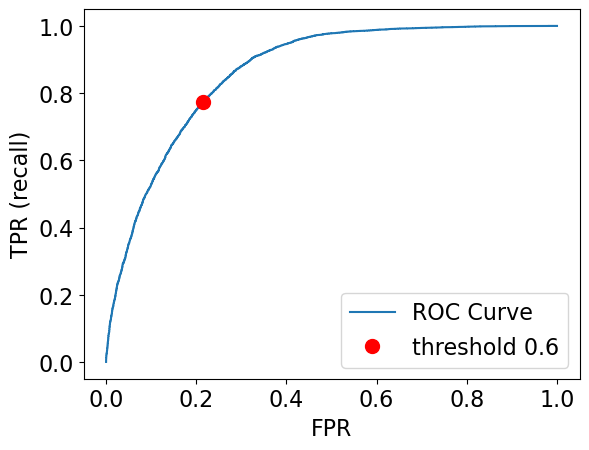

In [60]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, pipe_besthist.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.6))

plt.plot(fpr[default_threshold], tpr[default_threshold],
         "or", markersize=10, label="threshold 0.6")
plt.legend(loc="best")

### Area under the curve (AUC)

In [61]:
from sklearn.metrics import roc_auc_score

auc_hist = roc_auc_score(y_valid, pipe_besthist.predict_proba(X_valid)[:, 1])
auc_res["auc_hist"] = auc_hist
print("AUC for HistGradient classifier: {:.3f}".format(auc_hist))

AUC for HistGradient classifier: 0.865


In [62]:
print(X_train.shape)
print(X_test.shape)
#y_score =pipeline.score(X_test,y_test)

(143330, 23)
(106171, 23)


### Code for creating csv

In [63]:

id_column = pd.DataFrame(X_test["id"], columns=["id"])
y_predict_column = pd.DataFrame(y_predict[:,1], columns=["smoking"])

result_df = pd.concat([id_column, y_predict_column], axis=1)

# Save to a CSV file
result_df.to_csv('HistGradientBoostingClassifier_with_all_features.csv', index=False)

### Kaggle Score for Histgradient Boostclassifier 

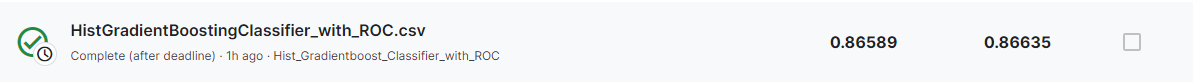

# Conclusion

In [64]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.142 (+/- 0.004),0.032 (+/- 0.002),0.500 (+/- 0.000),0.500 (+/- 0.000)
Decision_Tree,1.596 (+/- 0.003),0.040 (+/- 0.000),0.832 (+/- 0.002),0.865 (+/- 0.001)
KNN,0.165 (+/- 0.013),7.141 (+/- 0.285),0.844 (+/- 0.001),0.856 (+/- 0.000)
Logistic Regression,1.006 (+/- 0.059),0.039 (+/- 0.004),0.834 (+/- 0.001),0.834 (+/- 0.000)
Linear_svc,58.046 (+/- 1.097),0.055 (+/- 0.022),0.834 (+/- 0.001),0.834 (+/- 0.000)
Random_Forest,37.875 (+/- 0.597),0.861 (+/- 0.020),0.858 (+/- 0.002),0.941 (+/- 0.001)
XGboost,11.852 (+/- 0.196),0.082 (+/- 0.011),0.867 (+/- 0.002),0.888 (+/- 0.001)
HistGradientBoostingClassifier,2.345 (+/- 0.011),0.114 (+/- 0.002),0.865 (+/- 0.002),0.883 (+/- 0.000)


The model selection can be selected based on two parameters as detailed below

- Accuracy/ ROC: The XGBOOST  model demonstrated the highest accuracy in predicting the outcomes, with a mean cross-validation (CV) score of 0.867. This indicates its superior performance in generalizing to new, unseen data compared to other models we tested. This model gave a Kaggle score of 0.869.

- Efficiency   : Notably, the HISTGRADIENTBOOST model exhibited reasonable fit times, averaging 2 seconds. This efficiency makes it a practical choice for scenarios where rapid model training and prediction are essential.

- In conclusion, the XGBOOST model stands out as the most suitable choice for our predictive task, which requires the highest predictive accuracy and histgradient boost model is the second best  with highest This model is recommended for deployment in practical applications where both accuracy and computational efficiency are significant.